In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

## Single object trackng problem
Single object tracking - we know that there is a precisely 1 object

- no need to infer number of objects
- fewer data association hypotheses

3 closely related challenges due to more complicated measurement model

- missed detections - object detected with imperfect sensor that apart from the noise has the porbability of detection $P^D(x) \le 1$
- clutter detections - false detections that dont correspond to any object
- unknown data association - at any time its unknown which of given detections (if any) is an object detection 

### Useful statistical background

#### Some links
- [good link to datacamp](https://www.datacamp.com/community/tutorials/probability-distributions-python)
- [another good one YouTube crash course statistics](https://www.youtube.com/watch?v=WR0nMTr6uOo)

#### Bernoulli distribution

$p^k(p-1)^{1-k}$

Probability of success or a failure of an event with 1 trial is described by follow Bernoulli distribution (heads/tails, true/false quiz, for/against vote, detection/no detection, infected/not infected zombie). Here $k \in \lbrace0,1\rbrace$ Where $k = 1$ is sucess and $k = 0$ is failure.

Example:

[0.8 0.2 0.  0. ]


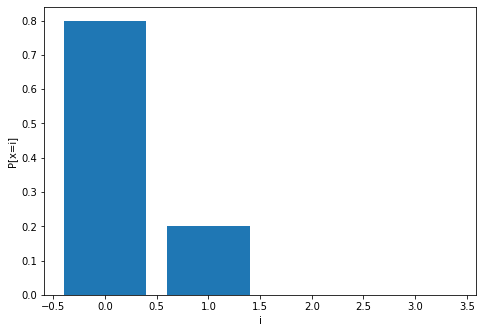

In [2]:
b = ss.bernoulli(0.2)
x = [0, 1, 2, 3]
p = b.pmf(x)
print(p)

# plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,p)
ax.set_ylabel('P[x=i]')
ax.set_xlabel('i')
plt.show()

#### Binomial distribution

The Bernoulli distribution is a special case of the binomial distribution where a single trial is conducted. Binomial distribution can also be understood as performing Bernoulli distribution multiple times in a row, using logical AND which corresponds to multiplication of probabilities.

$\binom{n}{k}p^k(p-1)^{n-k}$

Consider having a toaster with 20% probability to hit you with electric shock when making a toast.  You eat a toast every work day. What is the probability of getting hit 1 time during the work week.

Binomial formula contains 2 key parts:
- $p^k(p-1)^{n-k}$ accounts for the probability that event happens k out of n times and does not happen the rest of the times. In our example the probability of getting 1 shock on monday and 0 shocks during the rest of the week $0.2^1 0.8^{5-1} = 8.2\%$
- $\binom{n}{k}$ binomial coefficient accounts for in how many ways the specific event can happen. For our example we can get that one shock either early in the week or monday, or tuesday or any other day of the work week.  There are $n=5 \text( choose ) k=1$ or $\binom{5}{1} = 5$. There are 5 different ways we can receive one toaster shock during the week.

$\binom{5}{1}0.2^1 0.8^{5-1} = 41\%$

Lets look at another example. There is a 5% chance to that a person you meet on a way to a shelter is a zombie. There are 20 zombies on your way and you can only safely get to the shelter if you meet maximum 2 zombies. What is the probability of getting to the shelter.

In [3]:
# binomial distribution object
b = ss.binom(20, 0.05)
total_p = 0
for k in range(0,3):
    total_p += b.pmf(k)
print(total_p)

0.9245163262115033


The expected value of the Binomial distribution is $\mathbb{E}(x) = pn$

### Poisson distribution
Models number of events in a given interval (fx, but also other dimension like area). For example, the number of users visited on a website in an interval can be thought of a Poisson process. In our application its the number of clutter detections that can be modelled by Poisson. The events must be intependent as to say knowing how many clutter detections we have in time $t$ gives no information in determining how many clutter detections occur at time $t+1$. An event can occur $0,1,2,...$ times in an interval. The average number of events or event rate in an interval is designated $\lambda > 0$. The probability of observing $k$ events in an interval is given by the equation:

$$Po(X=k) = e^{-\lambda}\frac{\lambda^k}{k!}$$

On average student ask you 4 questions per day. Yesterday they asked 7 questions, what was the likelihood of that? In this question the event rate is $\lambda=4$ and the amount of events is $k=7$, furthermore the time interval is 1 day.

The expected value and variance is $\lambda$

### Measurement model
The application of SOT requires the extension of the original measurement model used in the Bayesian filtering framework. In particular we would like to account not only for the uncertain detections, but also for missing object detections and extra detections that dont correspond to the object also known as clutter.

### Measurement model acounting for non-zero probability of misdetection
The object is detected with probability of detection $ P^D(x)$ The probability of detection can be constant or depending on x, for example if x is predicted to be out of our sensors sight we know that probability of detection must be 0. The measurement model generates measurement from true state:

$p(o_k|x_k) = g_k(o_k|x_k)$

Object detection measurement is often assumed

$o_k = h_k(x_k) + v_k$ where $ v_k \backsim \mathcal{N}(0,R_k)$ so that $ g_k(o_k|x_k) = \mathcal{N}(o_k:h_k(x_k),R_k)$

Detections are represented with a matrix, or sequence. For SOT the O_k contains at most 1 vector with measurement. The point object model assumption says that there is 0 probability of the object to generate more than 1 detection.
$$O_k = \begin{cases} [] &\text{if object is undetected} \\ o_k &\text{if object is detected} \end{cases}$$

Number of column vectors in $O_k$ is represented as $|O_k|$ and given $x_k$, $|O_k|$ is Bernoulli distributed (1 with $P^D$ otherwise 0):

$$|O_k| = \begin{cases} 1 &\text{with probability }P^D(x_k) \\ 0 &\text{with probability }1-P^D(x_k)\end{cases}$$

Combining two concepts above we arrive at the distribution of object measurement matrix. It captures both **the probability of detection** and if detected **the distribution of the detection**:
$$p(O_k|x_k) = \begin{cases} 1-P^D(x_k) &\text{if }O_k = [] \\ P^D(x_k)g_k(o_k|x_k) &\text{if } O_k = o_k \end{cases}$$

Interpretation of the first part is that the undetected measurement is equally likely to be found anywhere no matter $x_k$, so in the update step we are essentially not feeding any new information, just scaling the result of the prior (motion model) by the factor $1 - P^D(x_k)$

Lets generate a few samples from that distribution. Lets assume $P^D(x_k) = 0.85$ and $g_k(o_k|x_k) = \mathcal{N}(o_k:[3, 2]^T, 0.3\mathbf{I})$
    [FilterPy]() is used to plot the covariance ellipse

In [41]:
from numpy.random import rand
from filterpy.stats import plot_covariance_ellipse

def sample_Ok(p, gk, **kwargs):
    '''Sample from measurement function gk
    with probability of detection p'''
    O_k = []
    if rand() < p:
        o_k = gk(**kwargs)
        O_k.append(o_k)
    return O_k

def gk(x, P, N=1):
    '''Produce N realizations from multivariate 
    Gaussian measurement model with mean x and 
    covariance matrix P'''
    return np.random.multivariate_normal(x, P, N)

def simulate_Ok_samples(pd, x, P):
    o_k = sample_Ok(pd, gk, **{"x":x, "P":P})
    print("o_k: ",o_k)
    ax = plt.axes()
  
    plot_covariance_ellipse(x, P, fc='b',
                        alpha=0.2, std=[1, 2, 3])
    if o_k:
        ax.plot(o_k[0][:,0], o_k[0][:,1], "rs")
    ax.set_xlim(-2,6)
    ax.set_ylim(-2,6)
    ax.set_ylabel('z1 [m]')
    ax.set_xlabel('z2 [m]')     
    plt.show()
# simulate


# Create update button
import ipywidgets as widgets
from IPython.display import display, clear_output
button = widgets.Button(description="Generate sample")
output = widgets.Output()

def on_click_simulate(b):
    pd = 0.85
    x = [3, 2]
    P = 0.3* np.eye(2)
    with output:
        clear_output()
        simulate_Ok_samples(pd, x, P)
    
button.on_click(on_click_simulate)
display(button, output)


Button(description='Generate sample', style=ButtonStyle())

Output()

### Known associations
Suppose data association is known
Given a set of measurements $Z_k$, we know the detections $O_k$, in other words, we are tracking without clutter, so as long as we detected something it is an object

How do we find posterior density $p(x_k|O_{1:k})$ in this case? We follow Bayesian filtering framework with prediction and update step. 

Prediction step does not change and follows Chapman-Kolmogorov equation in a general sense or Kalman filter prediction step in case of linear gaussian models.

Update step follows Bayes theorem so that posterior is proportional to prior (prediction step result) times measurement likelihood. Given the measurement model extended to account for misdetections we get:

$$ p(x_k|O_{1:k}) \propto p(x_k|O_{1:k-1})p(O_k|x_k) = \\ =
\begin{cases} 
p(x_k|O_{1:k-1})(1-P^D(x_k)) &\text{if }O_k = [] \\ 
p(x_k|O_{1:k-1})P^D(x_k)g_k(o_k|x_k) &\text{if } O_k = o_k \end{cases}$$

So under the assumption that we know $O_k$ we there is a straigth forward procedure for the update step. In the case where $P^D$ is constant it can even be eliminated from the update step. Then we either carry on with the motion model olny if $O_k$ is empty or perform the update including the measurement model if $O_k$ contains the detection.

Example:
Observe the motion constant velocity model


In [86]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
kf = KalmanFilter(dim_x=2, dim_z=1)

# motion model
dt = 1.0
kf.F[0,1] = dt
kf.Q = 0.5 * np.array([[1/3, 1/2],[1/2, 1]])
# initial state
kf.x = [1, 2]
kf.P = [[0.3, 0],[0, 1]]
# sensor model
kf.H = [1, 0]
kf.R = 1

def get_true_states(x0, v, N):
    x_true = np.array([[x0, v],]*N) 
    x_true[:,0] = np.linspace(start=x0, stop=x0 + v*(N-1),num=N)
    return x_true

def get_measurements(x_true, pd):
    x_true = np.array(x_true)
    N = x_true.shape[0]
    idx = rand(N) < pd
    noise = np.random.normal(0, 1, N)
    z = np.nan * np.ones(N)
    z[idx] = x_true[idx, 0] + noise[idx]
    return z

x_true = get_true_states(x0=1, v=2, N=10)
zs = get_measurements(x_true, pd=0.85)
print("measurements:",zs)

s = Saver(kf)
for z in zs:
    kf.predict()
    if z:
        kf.update(z)
    s.save()
        
def plot_motion():
# plot predicted
# plot posterior
# plot prior
# plot observation

[[ 1  2]
 [ 3  2]
 [ 5  2]
 [ 7  2]
 [ 9  2]
 [11  2]
 [13  2]
 [15  2]
 [17  2]
 [19  2]] [ 1.30049853  3.62915435  4.23672614  6.32717599         nan 11.11629545
 13.02271389 15.18144796 17.29554649         nan]


### Standard clutter model
General term for false detection, can come from sensor noise and incorrect detections

The measurement matrix that includes not only the object detections $O_k$ but also clutter detections $C_k$ is represented as follows:

$$Z_k = \Pi(O_k,C_k)$$

where the operator $\Pi$ randomly shuffles column vectors

To model clutter we need a stochastic model for the number of clutter detections $|C_k|$ as well as values of $C_k$

Field of view of sensor in $\mathbb{R}^{n_z}$ of volume V. $\lambda$ denotes expected number of clutter detections **per unit volume** (or per interval like in Poisson definition).

So if considered a field of view of 2D sensor being 2x2 units with $\lambda = 0.8$, it will give us on average $4 \cdot 0.8 = 3.2$ clutter points.

Consider a model when we split a volume into j cells corresponding to the sensor resolution, so that in one cell we can get at most 1 detection. $C_k^{(1)},...,C_k^{(j)}$ are independent and the fact of having a detection or not in each cell corresponding to $|C_k^{(i)}|$ is Bernoulli distributed:

$$|C_k^{(i)}| = 
\begin{cases}
1 &\text{with probability }\frac{\lambda V}{j} \\
0 &\text{with probability }1-\frac{\lambda V}{j}
\end{cases}
$$

Then if we have $j$ events deciding the existence of detection in a cell that are Bernoulli distributed, the total number of clutter detections $|C_k|$ in the volume is binomially distributed. The probability of getting $k$ clutter detections is thus:

$$Pr(k) = \binom{n}{k}p^k(p-1)^{n-k}$$ with total trials $n = j$ and detection probability $p = \frac{\lambda V}{j}$

Finally, if the cell contains the clutter detection $C_k^{(i)}$, the it is uniformly distributed within that cell.

What would then happen if we assume unlimited resolution and make $j$ smaller. It then follows:
- Probability to obtain more detections (more trials in binomial distribution)
- Probability of detection in a single cell decreases
-The mean amount of detection does not change $\mathbb{E(|C_k|)} = \lambda V$ for all $j$ since the mean of binomial distribution is $pj = \frac{\lambda V}{j}j = \lambda V$

As the number of cells increases $j \to \infty$
- $|C_k|$ is Poisson distributed
- $C_k$ is a Poisson point process

In [ ]:
# visualization of binomial converging to the Poisson
def draw_volume(V, j):
    pass
def draw_distributions(lambda, V, j):
    pass

### Poison point process
The Poisson point process (PPP) is standard model for clutter. The clutter matrix content is:

$$C_k = [c_k^1,...,c_k^{m^c_k}]$$

where the number of clutter $m^c_k$ is Poisson distributed:

$$m^c_k \backsim Po(\lambda V)$$

Given $m^c_k$ the vectors $[c_k^1,...,c_k^{m^c_k}]$ are independent and uniformly distribute accross the volume V.

$$c_k^i \backsim unif(V)$$

Lets generate samples from such PPP.

In [133]:
from numpy.random import random, poisson
def sample_ppp(lam, dx, dy):
    Ck = []
    mkc = poisson(lam * dx * dy)
    for i in range(mkc):
        ck = random(2) * np.array([dx, dy])
        print(ck)
        Ck.append(ck)
    return np.array(Ck)
        
def sample_ppp_vectorize(lam, V, N):
    pass

def draw_samples_2d(zs, dx, dy):
    ax = plt.axes()
    if zs.size > 0:
        ax.plot(zs[:,0], zs[:,1], "rs")
        for i, z in enumerate(zs):
            ax.text(z[0], z[1], f'$c_k^{{{i}}}$',
                   fontsize=14)
    ax.set_xlim([0, dx])
    ax.set_ylim([0, dy])
    ax.set_xlabel('z1 [m]')
    ax.set_ylabel('z2 [m]') 
    plt.show()

# Create update button
import ipywidgets as widgets
from IPython.display import display, clear_output
button = widgets.Button(description="Generate sample")
output = widgets.Output()

def on_click_simulate(b):
    with output:
        clear_output()
        zs = sample_ppp(0.4, dx=2, dy=3)
        draw_samples_2d(zs, dx=2, dy=3)
    
button.on_click(on_click_simulate)
display(button, output)

Button(description='Generate sample', style=ButtonStyle())

Output()

In general to parametrize clutter model one can use:
- an intensity function $\lambda_c(c) \ge 0$ that helps to model expeting more or less clutter in different regions
- combination of the rate and spatial pdf of clutter vectors:
$$
\begin{cases}
\bar{\lambda}_c = \int\lambda_c(c)dc & \text{rate} \\
f_c(c) = \frac{\lambda_c(c)}{\bar{\lambda_c}} & \text{spatial PDF}
\end{cases}
$$

In the previous example we used the uniformly distributed intensity function, that is $\lambda$ everywhere inside the field of view and 0 elsewhere:
$$ 
\lambda_c(c) =
\begin{cases}
\lambda & \text{if } c \in V \\
0 & \text{otherwise}
\end{cases}
$$
The following rate and spatial PDF correspond to such intensity function:
$$\bar{\lambda}_c = \lambda V$$
$$ 
f_c(c) =
\begin{cases}
\frac{1}{V} & \text{if } c \in V \\
0 & \text{otherwise}
\end{cases}
$$

Sampling from the generalized method is very similar, except for the fact that the $c_k$ are now not necessarily uniformly distributed and need to be  sampled from the prescribed spatial PDF $f_c(c)$

### PPP distribution
Probability of obtaining exactly mkc vectors AND given that

Sequence of data association hypotheses $\theta_{1:k} = (\theta_1,\theta_2, ..., \theta_k)$

Hypotheses can be $\theta_k = 0$ meaning object is not in the measurements, $\theta_k = 1$ meaning measurement 1 is the object $\theta_k = k$ measurement k is the object

Posterior includes contribution from all hypotheses, thus the likelihood function $p(x|Z)$ is a mixture of $m_k+1$ components since we get one component for each $\theta_k \in \lbrace0,1,..,m_k\rbrace$
$$p(x_k|Z_k) = \sum_{\theta_k}p(x|\theta_k,Z_k)Pr(\theta_k|Z_k)$$

For $\theta = 0$ the contribution to posterior probability is proportional to the prior

### Complete measurement model

Number of detections $ m_k$

$$
p(Z|x) =
\sum_{\theta=0}^{m}p(Z,m,\theta|x) = \\ =
(1-P^D(x))\frac{exp(-\bar{\lambda}_c)}{m!}\prod_{i=1}^{m}\lambda_{c}(z^i) +
\sum_{\theta=1}^{m}P^D(x)\frac{g_{k}(z^{\theta}|x)}{\lambda_{c}(z^{\theta})}
\frac{exp(-\bar{\lambda}_c)}{m!}\prod_{i=1}^{m}\lambda_{c}(z^i) \\ =
\lbrack
(1 - P^D(x)) + \sum_{\theta=1}^{m}P^D(x)\frac{g_{k}(z^{\theta}|x)}{\lambda_{c}(z^{\theta})}
\rbrack
\frac{exp(-\bar{\lambda}_c)}{m!}\prod_{i=1}^{m}\lambda_{c}(z^i)
$$

If the probability of detection is lower than 1.0 the likelihood function $p(Z|x)$ is a mixture of $m_k+1$ components since we get one component for each $\theta_k \in \lbrace0,1,..,m_k\rbrace$

At time k number of possible association **hypotheses** is $(m_k + 1)$

At time k number of possible association **sequences** is a combination of all association hypotheses which is $ \prod_{i=1}^k(m_i + 1)$

#### Complete SOT model example
Object likelihood $g_k(o_k|x_k)$ could be for example Gaussian $\mathcal{N}(o_k:x_k,0.2)$

Clutter intensity in region bound by $c_{max}$ (range or area for 1d and 2d respectively) 

$$\lambda(c) = \begin{cases} 0.4 &\text{if }|x| \le c_{max} \\ 0 &\text{otherwise} \end{cases}$$

Sequence of measurements $Z_{1:k} = (Z_1, Z_2, ..., Z_k)$ for example, a sequence of 3 measurements could be $Z_1 = [-1.3, 1.7]$, $Z_2 = [1.3]$ and $Z_3 =[-0.3, 2.3]$

### Update step

### Prediction step

In [ ]:
def draw_path():
    pass
def draw_prior():
    pass
def draw_posterior():
    pass